In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import seaborn as sns
import decimal
import glob
import plotly 
import plotly.plotly as py
from collections import OrderedDict
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
def indegZeroUsers(G):
    '''
    Select users with indegree zero
    
    '''
    indegrees=list(G.in_degree(G.nodes()))
    indegree_zero_users = [indegree[0] for indegree in indegrees if indegree[1] == 0 ]
    print (f'number of indeg zero users {len(indegree_zero_users)}')
    return indegree_zero_users

In [3]:
relationshipTypes=['creationTocreation', 'creationTocontribution', 'creationTosharing', 
                   'contributionTocreation', 'contributionTocontribution', 'contributionTosharing', 
                   'sharingTocreation', 'sharingTocontribution', 'sharingTosharing']

In [4]:
def influenceCascadeExtraction(root_list,G):
    '''
    Extracting influence cascades rooted from a given root users list.
    
    '''   

    influence_df = pd.DataFrame()
    root_child_df = pd.DataFrame()

    for root in root_list: 

        data=[] # a list contains the influence vectors of users in each levels of hierarchy 
        Queue=[] # a list wich store nodes tempararily 
        hopdists={} # distance from root to nodes. key: node, value: distance from root

        Queue.insert(0,root)    
        hopdists[root] = 0

        while len(Queue) > 0:
            currentNode = Queue.pop()
            hopdist = hopdists[currentNode]
            outEdges = G.out_edges(currentNode,True)
            for edge in outEdges:
                influenceVector= [edge[2]['creationTocreation'], edge[2]['creationTocontribution'], 
                                  edge[2]['creationTosharing'],edge[2]['contributionTocreation'],
                                  edge[2]['contributionTocontribution'],edge[2]['contributionTosharing'],
                                  edge[2]['sharingTocreation'],edge[2]['sharingTocontribution'],
                                  edge[2]['sharingTosharing']]
                child = edge[1]
                if not child in hopdists.keys(): # check whether the node is already counted
                    if len(data) < (hopdist+1):  
                        data.append([])          # create sublists in data list for each hop
                    # store influence vectors of nodes in their corresponding sublist in data list
                    data[hopdist].append(influenceVector) 
                    # add the child node to Queue to consider it as a parent node in the next rounds
                    Queue.insert(0,child)                 
                    hopdists[child] = hopdist + 1   
        
        ##### Characterization of influence vector components #####
        levelInfluenceValues=[zip(*hop) for hop in data]    
        for i in range(len(levelInfluenceValues)):
            # total influence by activity type at each level of the cascade 
            levelInfluenceValues[i] = [sum(j) for j in levelInfluenceValues[i]]  
        
        levels = list(range(1, len(levelInfluenceValues)+1))
        levelInfluenceValues = np.array(levelInfluenceValues).T # total linfluence values at each level by activity type
        
        for idx, l in enumerate(levelInfluenceValues):
            m = np.sum(l)
            levelInfluenceValues[idx] = np.array(l) / m  # normalized total influence at each level by activity type   

        this_root_influence_by_levels = {}
        for idx, relation in enumerate(relationshipTypes):
            this_root_influence_by_levels[relation]=levelInfluenceValues[idx]
        this_root_influence_by_levels = pd.DataFrame(this_root_influence_by_levels)
    
        this_root_influence_by_levels["level"]=levels 
        this_root_influence_by_levels["root"]=root
        influence_df = influence_df.append(this_root_influence_by_levels,ignore_index=True)  
        
        ##### node-level data extraction of cascades for statistical analysis #######
        cascade_node_data = {'node':list(dict(hopdists).keys()), 'node_level':list(dict(hopdists).values())}
        root_child_by_levels = pd.DataFrame(cascade_node_data)
        root_child_by_levels["root"] = root
        root_child_df = root_child_df.append(root_child_by_levels,ignore_index = True) 

    print('influenceCascades_df')
    print (influence_df.head())
    return influence_df, root_child_df

In [5]:
def CreateSankeyLinksAndNodes_dfs(flow_df):   
    '''
    Get links and nodes dataframes to create sankey plot using the median influence values of each influence type by level.
    Will return sankey_links_df and sankey_nodes_df.
    '''
    ############## link data to create sankey plot ###################
    sankey_links_df = flow_df.melt(id_vars=['level'])
    sankey_links_df['from_label'] = sankey_links_df.apply(lambda x: "C" if "contributionTo" in x.variable else ("S" if "sharingTo" in x.variable else "I"),axis=1)
    sankey_links_df['to_label'] = sankey_links_df.apply(lambda x: "C" if "Tocontribution" in x.variable else ("S" if "Tosharing" in x.variable else "I"),axis=1)
    sankey_links_df['from_id_temp'] = (sankey_links_df.level-1).astype(str) + sankey_links_df.from_label
    sankey_links_df['to_id_temp'] = sankey_links_df.level.astype(str) + sankey_links_df.to_label
    #print(sankey_links_df)

    ###### Reassign from_id_temp and to_id_temp with integers. To create sankey plot, nodes ids should be integers######
    node_id = sankey_links_df.drop_duplicates('from_id_temp')[['from_id_temp']]
    node_id = node_id.append(sankey_links_df.drop_duplicates('to_id_temp')[['to_id_temp']])
    #### CHECK    
    node_id['node_id_temp'] = node_id.from_id_temp.combine_first(node_id.to_id_temp)
    node_id = node_id.drop_duplicates('node_id_temp',keep='first').drop(['from_id_temp', 'to_id_temp'], axis = 1)
    node_id['node_id'] = np.arange(len(node_id))

    
    sankey_links_df = pd.merge(sankey_links_df, node_id, how = 'left', left_on='from_id_temp', right_on='node_id_temp',sort = False ).drop(['node_id_temp', 'from_id_temp'], axis = 1).rename(columns = {'node_id': 'from_id'})   #reassign the temp_from_id 
    sankey_links_df = pd.merge(sankey_links_df, node_id, how = 'left', left_on='to_id_temp', right_on='node_id_temp',sort = False ).drop(['node_id_temp','to_id_temp'], axis = 1).rename(columns = {'node_id': 'to_id'}) #reassign the temp_to_id
    sankey_links_df['link_color'] = np.where((sankey_links_df.from_label == "C"), "rgb(144,237,244)", np.where((sankey_links_df.from_label == "I"),"rgb(247,203,81)", "rgb(225,174,242)"))

#     sankey_links_df.to_csv("output/sankey_links_df.csv")
    
    ################## node data to create sankey plot #################

    sankey_nodes_df = sankey_links_df.drop_duplicates("from_id")[["from_id","from_label"]].astype(str)
    sankey_nodes_df = sankey_nodes_df.append(sankey_links_df.drop_duplicates("to_id")[["to_id","to_label"]].astype(str))
    sankey_nodes_df['node_id'] = sankey_nodes_df.from_id.combine_first(sankey_nodes_df.to_id)
    sankey_nodes_df['node_label'] = sankey_nodes_df.from_label.combine_first(sankey_nodes_df.to_label)
    sankey_nodes_df = sankey_nodes_df.drop(['from_id', 'from_label', 'to_id', 'to_label'], axis = 1).drop_duplicates(['node_id', 'node_label'])
    sankey_nodes_df['node_color'] = np.where((sankey_nodes_df.node_label == "C"),"rgb(60,222,234)",np.where((sankey_nodes_df.node_label == "I"),"rgb(232,176,25)", "rgb(213,128,242)"))

    #print(sankey_nodes_df)
#     sankey_nodes_df.to_csv("output/sankey_nodes_df.csv")

    return sankey_links_df,sankey_nodes_df

In [6]:
########################## plotting sankey graph ##############################

def plotSankey(sankey_links_df,sankey_nodes_df):
    #plotly.tools.set_credentials_file(username='username', api_key='api_key')
    data = dict(
        type='sankey',
        arrangement = "freeform",
        opacity = 0.1,
        showlegend = True,
        textfont = dict (
            color = "black",
            size = 1, 
            family = "Droid Serif"      
        ),
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        node = dict(
          pad = 15,
          thickness = 30,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = sankey_nodes_df['node_label'].dropna(axis=0, how='any'),
          color = sankey_nodes_df['node_color'].dropna(axis=0, how='any')
        ),
        link = dict(
          source = sankey_links_df['from_id'],
          target = sankey_links_df['to_id'],
          value = sankey_links_df['value'],
          color = sankey_links_df['link_color'].dropna(axis=0, how='any')
      ))

    layout =  dict(
        #title = "Basic Sankey Diagram",
        autosize = False,
        height = 800,
        width = 1800,
        font = dict(
          size = 10
        )
    )

    fig = dict(data=[data], layout=layout)
    py.plot(fig)

In [7]:
#####  Generate scale-free networks with n number of nodes ######
def generateScaleFreeNetworks(n):
    G_scaleFree = nx.scale_free_graph(n, seed=30)# scale free graph with default probabilities (alpha=0.41, beta=0.54, gamma=0.05, delta_in=0.2, delta_out=0, create_using=None,)

    np.random.seed(0)
    def setDecimals(x):
        decimal.getcontext().prec = 10  # 10 decimal points enough
        return decimal.Decimal(0) + decimal.Decimal(x)
    # this should include both boundaries as float gets close enough to 1 to make decimal round

    edges = list(set(G_scaleFree.edges()))
    scalefree_network = pd.DataFrame(edges, columns = ["userID1","userID0" ], dtype= str)
    scalefree_network = scalefree_network[scalefree_network["userID0"]!= scalefree_network["userID1"]]
    for action in relationshipTypes:
        scalefree_network[action] = np.random.uniform(0,1, scalefree_network.shape[0])
        scalefree_network[action] = scalefree_network[action].apply(lambda x: setDecimals(x)).astype(float) 
    scalefree_inflnetwork = scalefree_network[scalefree_network.iloc[:,2:].sum(axis=1) > 0]
    return scalefree_inflnetwork


In [8]:
###### plotting average number of users and rate of connectivity of users by level #######

def userPlots(child_root_df,hue_order_list,colors): # hue_order_list: hue order as a list; colors: colors for elements as a list
    user_count_at_levels = child_root_df.groupby(["platform_community","root","node_level"]).size().reset_index().rename(columns={0:"num_nodes"})
    avg_user_count_at_levels = user_count_at_levels.groupby(["platform_community","node_level"]).mean().reset_index()
    std_user_count_at_levels = user_count_at_levels.groupby(["platform_community","node_level"]).std().reset_index()
    avg_user_count_at_levels["diff"] = avg_user_count_at_levels.groupby("platform_community")["num_nodes"].diff(periods=1)
    avg_user_count_at_levels["cumulative_sum_of_users"]= avg_user_count_at_levels.groupby("platform_community")["num_nodes"].apply(lambda x: x.cumsum())


#     fig, (ax,ax1,ax2,ax3) = plt.subplots(nrows=4,figsize=(10,20))
    fig, (ax,ax2,ax3) = plt.subplots(nrows=3,figsize=(10,20))
    sns.barplot (x="node_level", y="num_nodes", hue = "platform_community",hue_order = hue_order_list,palette=colors,data = avg_user_count_at_levels, ax=ax)
    ax.set_xlabel("Level", fontsize=20)
    ax.set_ylabel("Total Number of Users", fontsize=20)
    plt.setp(ax.get_xticklabels(), rotation=0, fontsize=16)
    plt.setp(ax.get_yticklabels(),fontsize=16)
#     plt.legend(fontsize=12)
    handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles=handles[1:], labels=labels[1:])
    ax.legend(loc='upper right', bbox_to_anchor=(1,1),prop=dict(size=20))
    
#     sns.barplot (x="node_level", y="cumulative_sum_of_users", hue = "platform_domain",hue_order = hue_order_list,palette=colors,data = avg_user_count_at_levels, ax=ax1)
#     ax1.set_xlabel("Level of Influencees", fontsize=14)
#     ax1.set_ylabel("Cumulative Sum of Influencees", fontsize=14)
#     plt.setp(ax1.get_xticklabels(), rotation=0, fontsize=12)
#     plt.setp(ax1.get_yticklabels(),fontsize=12)
#     plt.legend(fontsize=12)

    sns.lineplot(x=avg_user_count_at_levels["node_level"], y=avg_user_count_at_levels["cumulative_sum_of_users"],hue = "platform_community",hue_order = hue_order_list,palette=colors,data = avg_user_count_at_levels, ax=ax2)
    ax2.grid(True)
    ax2.set_xlabel("Level", fontsize=20)
    ax2.set_ylabel("Cumulative Sum of Users", fontsize=20)
    plt.setp(ax2.get_xticklabels(), rotation=0, fontsize=16)
    plt.setp(ax2.get_yticklabels(),fontsize=16)
#     plt.legend(fontsize=12)
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles=handles[1:], labels=labels[1:],loc='lower right', bbox_to_anchor=(1,0),prop=dict(size=20))

    sns.lineplot(x="node_level", y="diff", hue = "platform_community",hue_order = hue_order_list,palette=colors,data = avg_user_count_at_levels, ax=ax3)
    ax3.grid(True)
    ax3.set_xlabel("Level of Influencees", fontsize=20)
    ax3.set_ylabel("Rate of Change of Number of Influencees", fontsize=20)
    plt.setp(ax3.get_xticklabels(), rotation=0, fontsize=16)
    plt.setp(ax3.get_yticklabels(),fontsize=16)
#     plt.legend(fontsize=12)
    handles, labels = ax3.get_legend_handles_labels()
    ax3.legend(handles=handles[1:], labels=labels[1:],loc='upper right', bbox_to_anchor=(1,1),prop=dict(size=20))

#     handles, labels = [(a + b) for a, b in zip(ax.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
#     print(handles)
#     print(labels)
#     fig.legend(handles=handles[1:], labels=labels[1:], loc="upper center")
#     plt.legend( lines, labels, loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
#             bbox_transform = plt.gcf().transFigure )

#     plt.savefig("/home/social-sim/hierarchy/influence_hierarchical_structures/Untitled Folder/output/user_plots.png")
    plt.show()

In [9]:
platforms = ["GitHub","Twitter"]
communities = ["Crypto","CVE"]
empirical_inflcascades_df = pd.DataFrame()
empirical_rootchild_df = pd.DataFrame()
empirical_inflnetworks_nodecount = OrderedDict()
scalefree_inflcascades_df = pd.DataFrame()
scalefree_rootchild_df = pd.DataFrame()

for platform in platforms:
    for community in communities:
        platform_community = str(platform)+"_"+str(community)
        inflnetwork_gt=pd.read_csv("input_data/"+platform_community+"_Influence_Network_df.csv")
        print (platform_community)
        G=nx.from_pandas_edgelist(inflnetwork_gt,'userID0','userID1',inflnetwork_gt.columns.tolist()[2:],
                                   create_using=nx.DiGraph())
        empirical_inflnetworks_nodecount[platform_community] = G.number_of_nodes()
        indeg_zero_users = indegZeroUsers(G) # finding in-degree zero nodes (source nodes) in the influence network
        inflcascades_df, root_child_df = influenceCascadeExtraction(indeg_zero_users,G) # extracting influence cascades of source nodes
        gt_infl_medians_by_level_and_type_df = inflcascades_df.groupby(by=["level"]).median().fillna(0).reset_index() #taking the median of noramlized total influence vector components 
        sankey_links_df,sankey_nodes_df = CreateSankeyLinksAndNodes_dfs(gt_infl_medians_by_level_and_type_df) # creating nodes and flow(links) dataframes for visualization 
        plotSankey(sankey_links_df,sankey_nodes_df) # plotting influence cascades through Sankey diagram
        
        #### storing influence cascades dfs and root_child dfs for statistical analysis ###### 
        inflcascades_df["platform"] = platform
        inflcascades_df["community"] = community
        empirical_inflcascades_df = empirical_inflcascades_df.append(inflcascades_df)
        root_child_df["platform"] = platform
        root_child_df["community"] = community
        root_child_df["platform_community"] = platform_community
        empirical_rootchild_df = empirical_rootchild_df.append(root_child_df)
        
        #### comparison with scale-free networks ######
        scalefree_inflnetwork = generateScaleFreeNetworks(G.number_of_nodes()) #generating scale-free networks with equal number of nodes in empirical network
#         scalefree_inflnetwork.to_csv(str(platform_community)+"_SF_Influence_Network_df.csv", index = False)  # saving the influence naetwork data of scale-free networks if needed
        G_SF = nx.from_pandas_edgelist(scalefree_inflnetwork,'userID0','userID1',inflnetwork_gt.columns.tolist()[2:],
                                   create_using=nx.DiGraph())
        indeg_zero_users_SF = indegZeroUsers(G_SF) # finding in-degree zero nodes (source nodes) in the influence network
        inflcascades_df_SF, root_child_df_SF = influenceCascadeExtraction(indeg_zero_users_SF,G_SF) # extracting influence cascades of source nodes
        SF_infl_medians_by_level_and_type_df = inflcascades_df_SF.groupby(by=["level"]).median().fillna(0).reset_index() #taking the median of noramlized total influence vector components 
        SF_sankey_links_df,SF_sankey_nodes_df = CreateSankeyLinksAndNodes_dfs(SF_infl_medians_by_level_and_type_df) # creating nodes and flow(links) dataframes for visualization
        plotSankey(SF_sankey_links_df,SF_sankey_nodes_df) # plotting influence cascades through Sankey diagram
        
        #### Storing influence cascades dfs of scale-free networks for statistical analysis #####
        inflcascades_df_SF["platform"] = platform
        inflcascades_df_SF["community"] = community
        scalefree_inflcascades_df = scalefree_inflcascades_df.append(inflcascades_df_SF)
        root_child_df_SF["platform"] = platform
        root_child_df_SF["community"] = community
        root_child_df_SF["platform_community"] = "SF_"+ str(platform_community)
        scalefree_rootchild_df = scalefree_rootchild_df.append(root_child_df_SF)
        
        
# empirical_inflcascades_df.to_csv("empirical_influence_cascades_df.csv", index=False)
# empirical_rootchild_df.to_csv("empirical_rootchild_df.csv",index=False)
# scalefree_inflcascades_df.to_csv("scalefree_influence_cascades_df.csv", index=False)
# scalefree_rootchild_df.to_csv("scalefree_rootchild_df.csv", index=False)
        



GitHub_Crypto
number of indeg zero users 568


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning:

invalid value encountered in true_divide



influenceCascades_df
   creationTocreation  creationTocontribution  creationTosharing  \
0                 0.0                     0.0                NaN   
1                 1.0                     1.0                NaN   
2                 0.0                     0.0                NaN   
3                 0.0                     0.0                NaN   
4                 1.0                     1.0                NaN   

   contributionTocreation  contributionTocontribution  contributionTosharing  \
0                0.000000                    0.024282               0.000000   
1                1.000000                    0.942253               0.903609   
2                0.000000                    0.033464               0.096391   
3                0.000000                    0.020674               0.000000   
4                0.970825                    0.872838               0.696630   

   sharingTocreation  sharingTocontribution  sharingTosharing  level  \
0                

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning:

invalid value encountered in true_divide



influenceCascades_df
   creationTocreation  creationTocontribution  creationTosharing  \
0                 NaN                     NaN                NaN   
1                 NaN                     NaN                NaN   
2                 NaN                     NaN                NaN   
3                 NaN                     NaN                NaN   
4                 NaN                     NaN                NaN   

   contributionTocreation  contributionTocontribution  contributionTosharing  \
0                     NaN                    0.005364                    0.0   
1                     NaN                    0.557443                    1.0   
2                     NaN                    0.357710                    0.0   
3                     NaN                    0.062333                    0.0   
4                     NaN                    0.017149                    0.0   

   sharingTocreation  sharingTocontribution  sharingTosharing  level  \
0                

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning:

invalid value encountered in true_divide



influenceCascades_df
   creationTocreation  creationTocontribution  creationTosharing  \
0            0.000000                0.000000           0.000000   
1            1.000000                0.980239           0.997837   
2            0.000000                0.019761           0.002163   
3            0.000000                0.000000           0.000000   
4            0.989963                0.926445           0.976918   

   contributionTocreation  contributionTocontribution  contributionTosharing  \
0                0.462185                    0.230130               0.154804   
1                0.537815                    0.769870               0.845196   
2                0.000000                    0.000000               0.000000   
3                0.028594                    0.118620               0.099755   
4                0.951029                    0.569465               0.821245   

   sharingTocreation  sharingTocontribution  sharingTosharing  level  \
0           0.289

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning:

invalid value encountered in true_divide



influenceCascades_df
   creationTocreation  creationTocontribution  creationTosharing  \
0            0.625103                     1.0           0.277282   
1            0.184380                     0.0           0.205079   
2            0.190517                     0.0           0.517639   
3            0.000000                     0.0           0.000000   
4            0.889459                     1.0           1.000000   

   contributionTocreation  contributionTocontribution  contributionTosharing  \
0                     0.0                         NaN                    0.0   
1                     1.0                         NaN                    1.0   
2                     0.0                         NaN                    0.0   
3                     NaN                         NaN                    0.0   
4                     NaN                         NaN                    0.0   

   sharingTocreation  sharingTocontribution  sharingTosharing  level  \
0           0.000

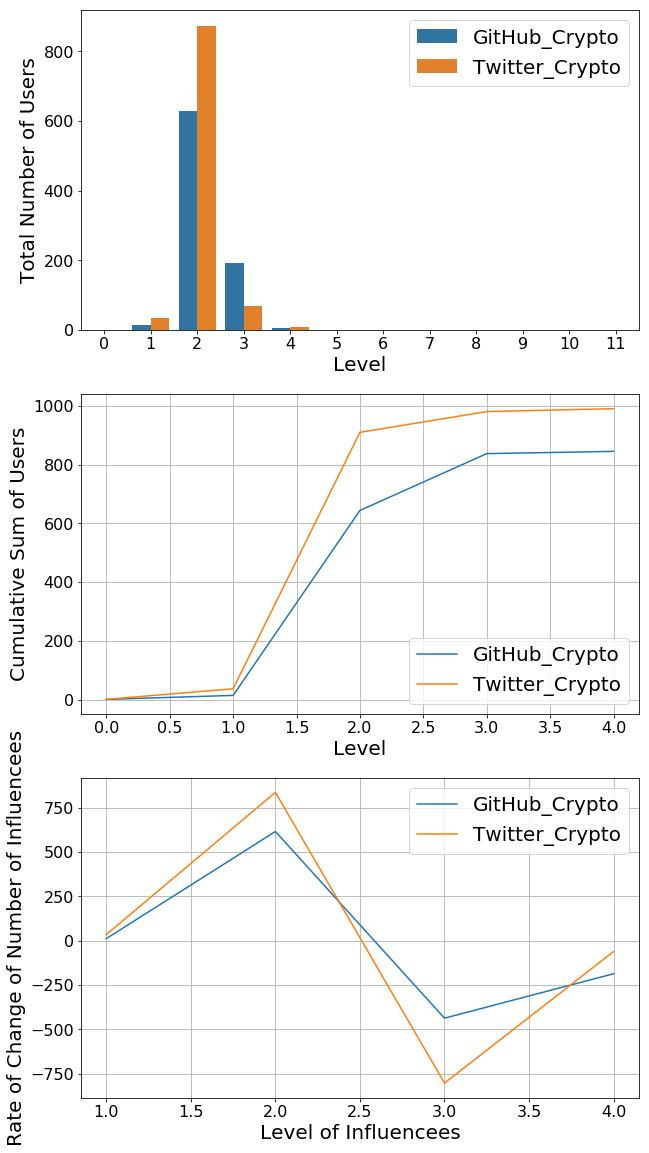

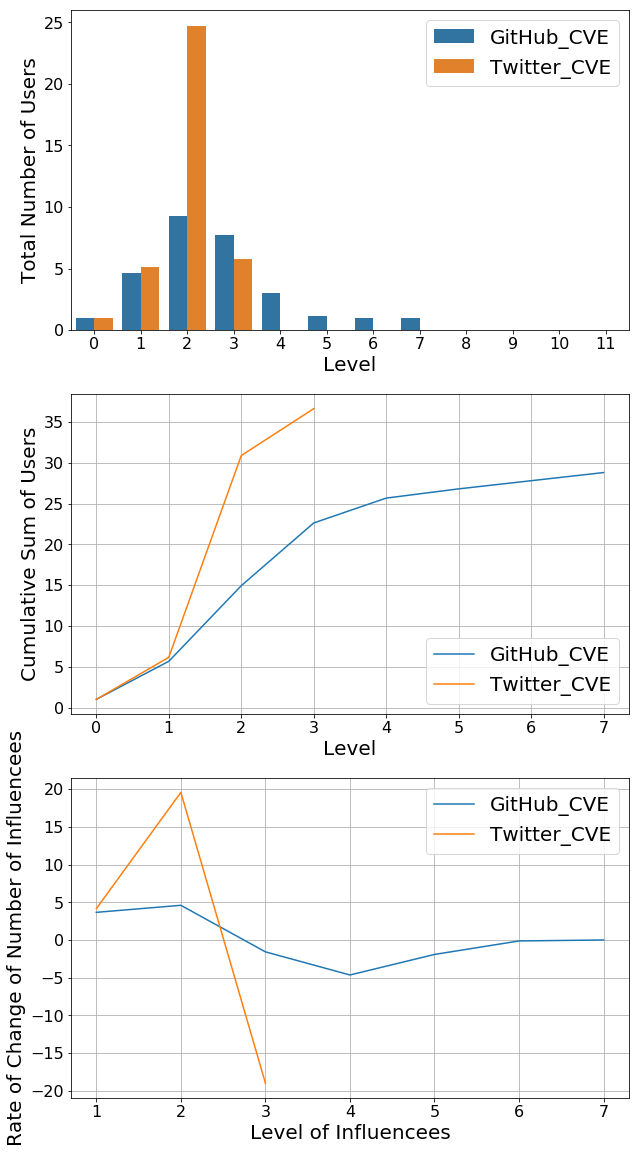

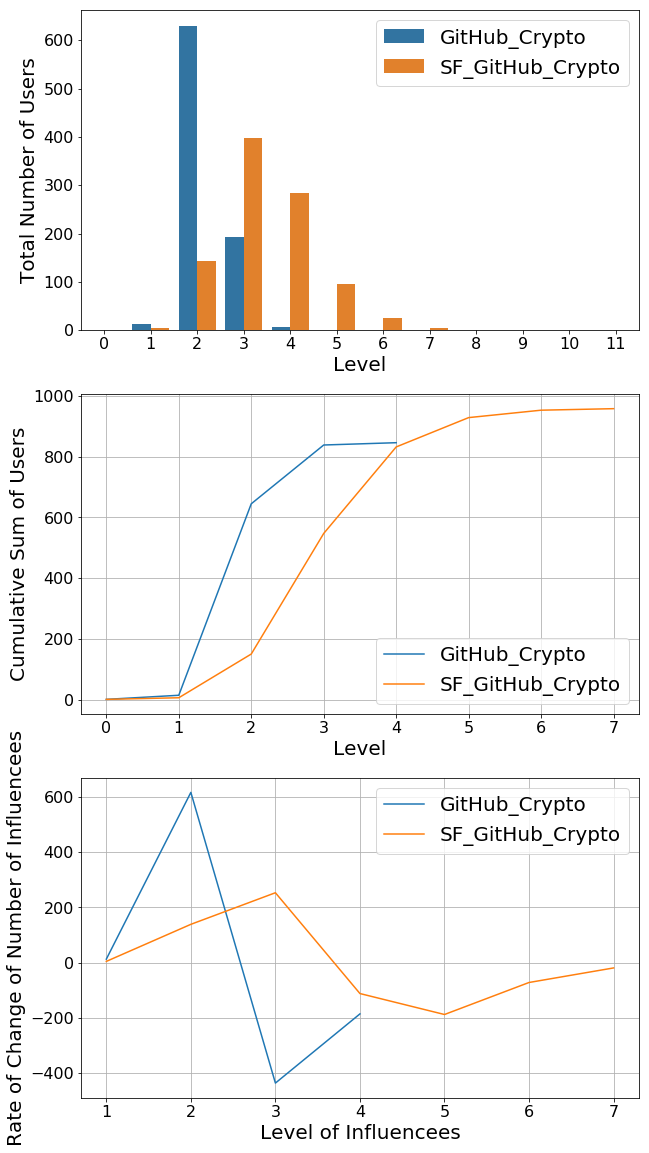

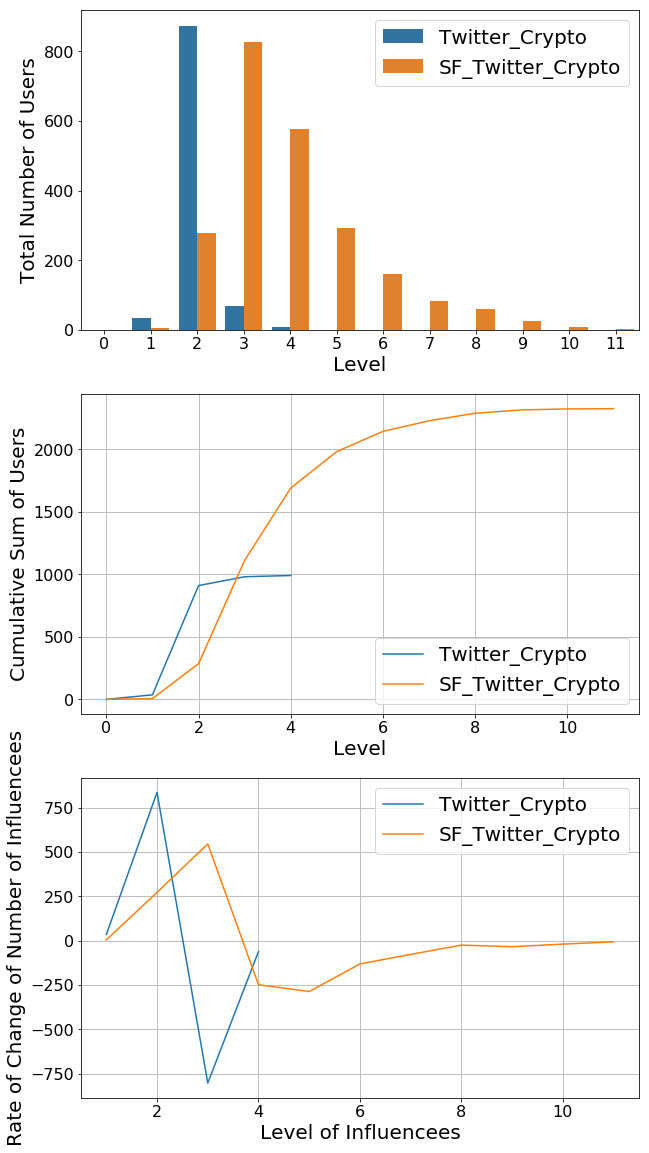

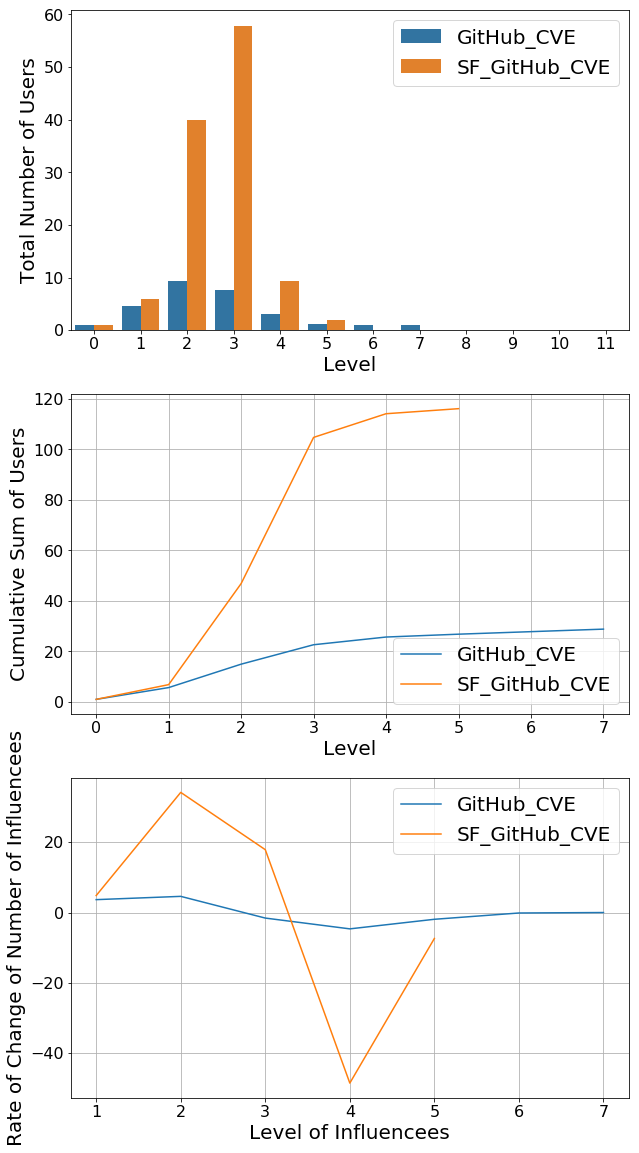

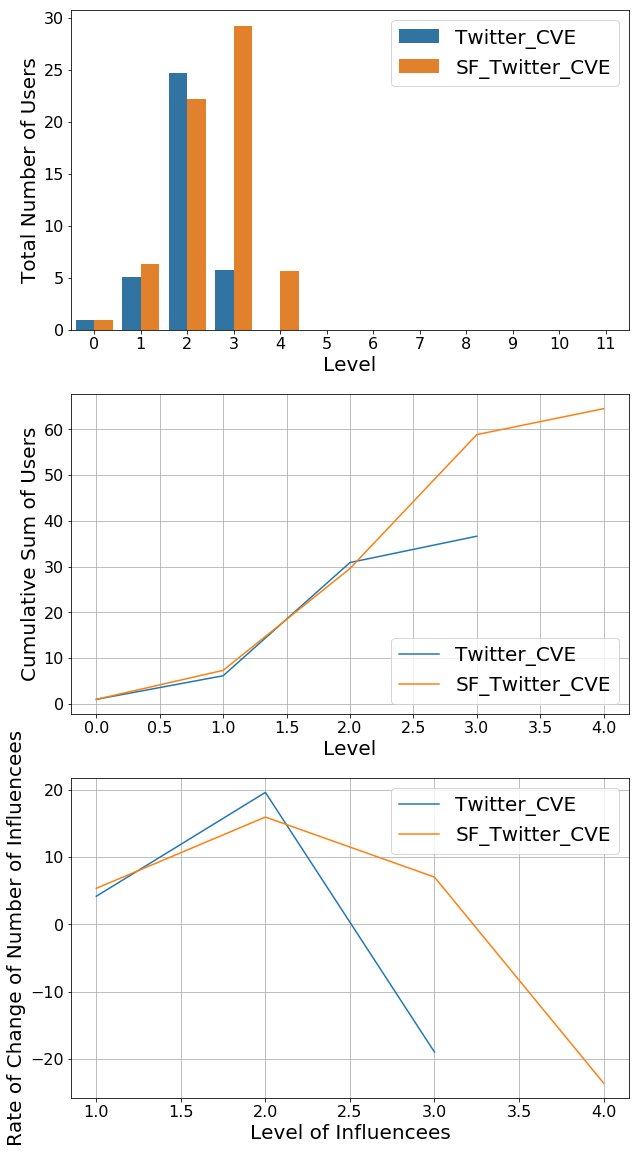

In [10]:
#### Plotting user distribution/connectivity graphs #####
rootchild_data = pd.concat([empirical_rootchild_df,scalefree_rootchild_df], axis=0)
#Comparisons by platforms #
userPlots(rootchild_data,["GitHub_Crypto", "Twitter_Crypto"],["C0", "C1"]) 
userPlots(rootchild_data,["GitHub_CVE","Twitter_CVE"],["C0", "C1"]) 
#Comparisons of platform_community vs scale-free #
userPlots(rootchild_data,["GitHub_Crypto","SF_GitHub_Crypto"],["C0", "C1"])
userPlots(rootchild_data,["Twitter_Crypto","SF_Twitter_Crypto"],["C0", "C1"])
userPlots(rootchild_data,["GitHub_CVE","SF_GitHub_CVE"],["C0", "C1"])
userPlots(rootchild_data,["Twitter_CVE","SF_Twitter_CVE"],["C0", "C1"])




/opt/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



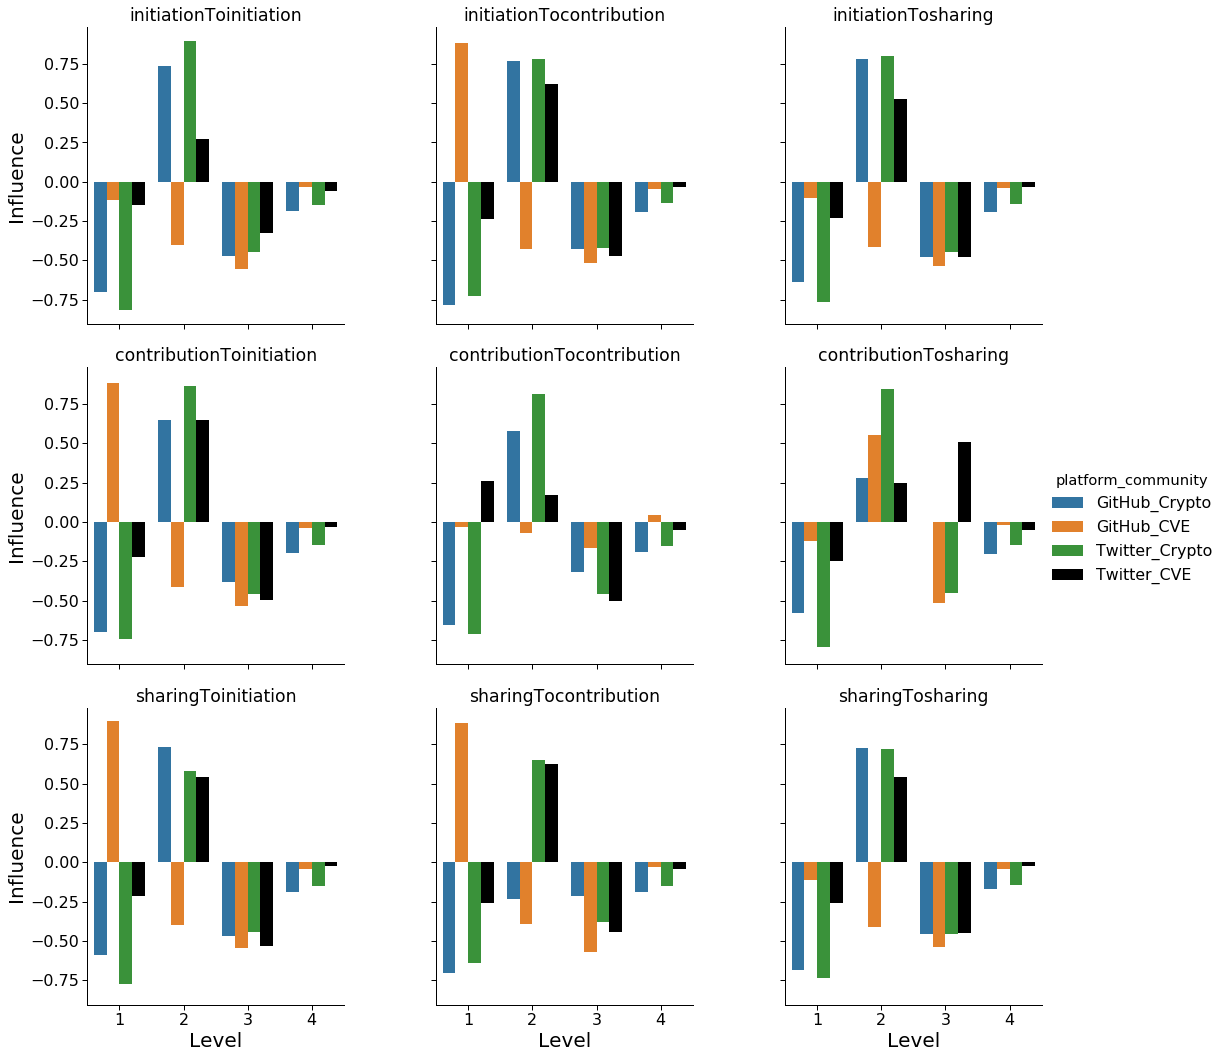

             inf_relationship  GitHub_Crypto/GitHub_CVE_coef  \
0      initiationToinitiation                            0.0   
1    initiationTocontribution                           -0.4   
2         initiationTosharing                            0.0   
3    contributionToinitiation                           -0.4   
4  contributionTocontribution                            0.0   
5       contributionTosharing                            0.4   
6         sharingToinitiation                           -0.4   
7       sharingTocontribution                           -0.4   
8            sharingTosharing                            0.0   

   GitHub_Crypto/GitHub_CVE_p  Twitter_Crypto/Twitter_CVE_coef  \
0                         1.0                              0.8   
1                         0.6                              0.8   
2                         1.0                              0.8   
3                         0.6                              0.8   
4                         1.0

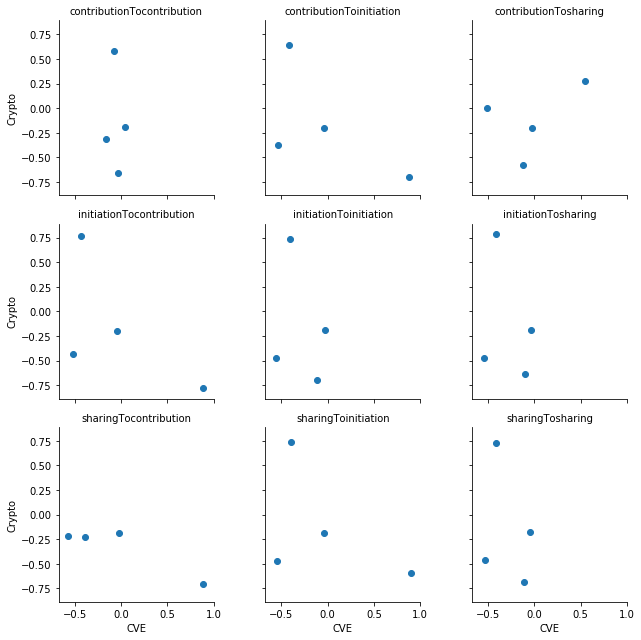

Twitter


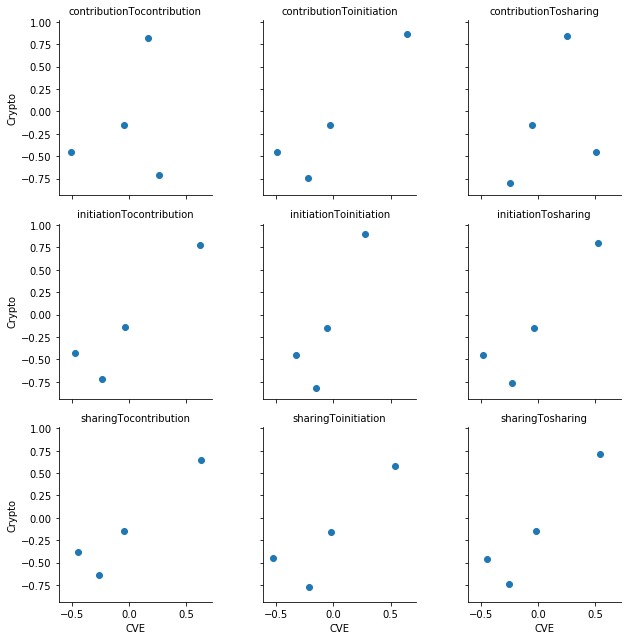

Crypto


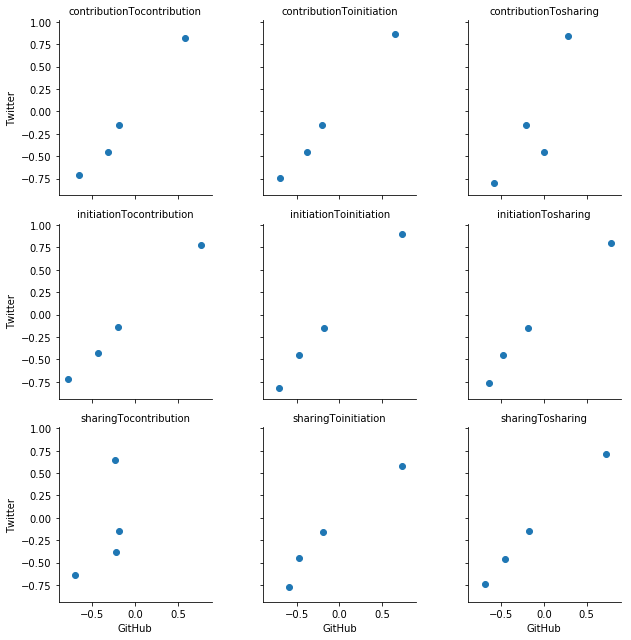

CVE


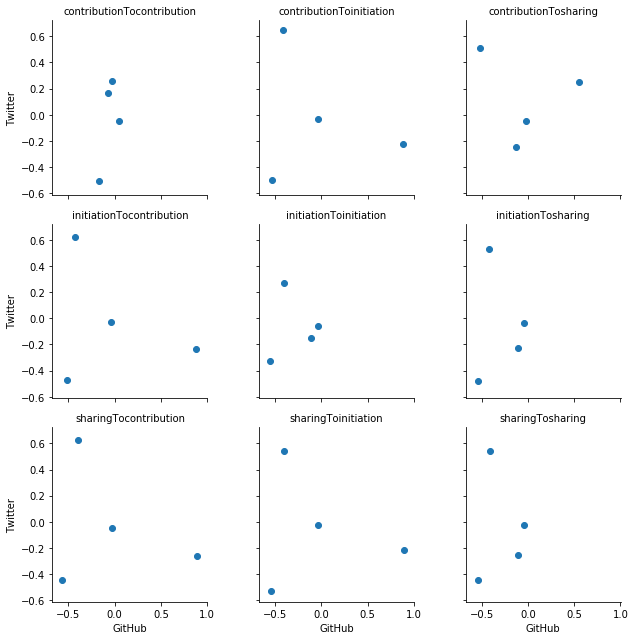

In [60]:
'''

'''
####Compare median values of normalized total influences between scalfree network and considered OSN influence network ######
empirical_inflcascades_medians = empirical_inflcascades_df.groupby(by=["platform","community","level"]).median().fillna(0).reset_index() #taking the median of noramlized total influence vector components 
scalefree_inflcascades_meidans = scalefree_inflcascades_df.groupby(by=["platform","community","level"]).median().fillna(0).reset_index()
residual_df = empirical_inflcascades_medians.set_index(["platform","community","level"]).subtract(scalefree_inflcascades_meidans.set_index(["platform","community","level"]), fill_value=0).reset_index()
residual_df["platform_community"]=residual_df["platform"]+"_"+residual_df["community"]
supremum_level=min(list(residual_df.groupby(["platform_community"])["level"].max()))
truncated_residual_df = residual_df[residual_df["level"]<=supremum_level]

###### Plotting median_residuals #######
df=pd.melt(truncated_residual_df, id_vars=["level","platform_community"], value_vars=truncated_residual_df.columns[3:-1],
           var_name="inf_relationship", value_name="influence")
df["inf_relationship"]=df["inf_relationship"].str.replace("creation","initiation") # replace the word "creation" by "initiation"
with sns.plotting_context("paper",font_scale=1.8):
    f=sns.factorplot(x="level", y="influence", hue="platform_community",
                   hue_order = ["GitHub_Crypto","GitHub_CVE","Twitter_Crypto","Twitter_CVE"],
                   palette=["C0","C1","C2","k"],col='inf_relationship',col_wrap=3,data=df, kind='bar')

    f.set_xticklabels(fontsize= 16)
    f.set_yticklabels(fontsize= 16)
    f.set_xlabels("Level",fontsize= 20)
    f.set_ylabels("Influence",fontsize= 20)
    f.set_titles("{col_name}",fontsize=18)
# f._legend(fontsize=20)
# plt.legend(loc=3, bbox_to_anchor=(0,1),
#        ncol=4, mode="expand", borderaxespad=0.,prop=dict(size=20))
plt.show()

##### Spearman's correlation test between platforms and community by influence relationships (only first four levels are considered)####

    

def corrByRelationship(df1,df2):
    corr_coef_by_relationship = {}
    corr_p_by_relationship = {}
    for relation in relationshipTypes:
        corr_coef_by_relationship[relation]=scipy.stats.spearmanr(np.array(df1[relation]), np.array(df2[relation]))[0]
        corr_p_by_relationship[relation]=scipy.stats.spearmanr(np.array(df1[relation]), np.array(df2[relation]))[1]
    return corr_coef_by_relationship,corr_p_by_relationship


spearmann_df = pd.DataFrame(columns=["inf_relationship"])
spearmann_df["inf_relationship"]=relationshipTypes
for platform in ["GitHub","Twitter"]:
    df1 = truncated_residual_df[truncated_residual_df["platform_community"]==platform+"_Crypto"]
    df2 = truncated_residual_df[truncated_residual_df["platform_community"]==platform+"_CVE"]
    coeff,pvalue = corrByRelationship(df1,df2)
    spearmann_df[platform+"_Crypto/"+platform+"_CVE_coef"]=spearmann_df["inf_relationship"].map(coeff)
    spearmann_df[platform+"_Crypto/"+platform+"_CVE_p"]=spearmann_df["inf_relationship"].map(pvalue)
for community in ["Crypto","CVE"]:
    df1 = truncated_residual_df[truncated_residual_df["platform_community"]=="GitHub_"+community]
    df2 = truncated_residual_df[truncated_residual_df["platform_community"]=="Twitter_"+community]
    coeff,pvalue = corrByRelationship(df1,df2)
    spearmann_df["GitHub_"+community+"/Twitter_"+community+"_coef"]=spearmann_df["inf_relationship"].map(coeff)
    spearmann_df["GitHub_"+community+"/Twitter_"+community+"_p"]=spearmann_df["inf_relationship"].map(pvalue)
spearmann_df=spearmann_df.fillna(0) 
spearmann_df["inf_relationship"]=spearmann_df["inf_relationship"].str.replace("creation","initiation") # replace the word "creation" by "initiation"
spearmann_df.to_csv("spearmannStats.csv") 
print(spearmann_df)


##### Visual representation of Median normalized total influence values across platforms and comminities by 
#####influence relationships
for platform in ["GitHub","Twitter"]:
    df3= truncated_residual_df[truncated_residual_df["platform"]==platform].drop(columns="platform")
    df3=pd.melt(df3, id_vars=["level","community"], 
            value_vars=truncated_residual_df.columns[3:-1],var_name="inf_relationship", value_name="influence")
    df3 = pd.pivot_table(df3,values="influence", index=["level","inf_relationship"],columns="community").reset_index()
    df3["inf_relationship"]=df3["inf_relationship"].str.replace("creation","initiation")
    g = sns.FacetGrid(df3, col="inf_relationship",col_wrap=3)
    g = (g.map(plt.scatter, "CVE", "Crypto").set_titles("{col_name}"))
    print(platform)
    plt.show()
    
for community in ["Crypto", "CVE"]:
    df4= truncated_residual_df[truncated_residual_df["community"]==community].drop(columns="community")
    df4=pd.melt(df4, id_vars=["level","platform"], 
            value_vars=truncated_residual_df.columns[3:-1],var_name="inf_relationship", value_name="influence")
    df4 = pd.pivot_table(df4,values="influence", index=["level","inf_relationship"],columns="platform").reset_index()
    df4["inf_relationship"]=df4["inf_relationship"].str.replace("creation","initiation") 
    g = sns.FacetGrid(df4, col="inf_relationship",col_wrap=3)
    g = (g.map(plt.scatter, "GitHub", "Twitter").set_titles("{col_name}"))
    print(community)
    plt.show() 

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1678: UserWarning:

Input data for shapiro has range zero. The results may not be accurate.



Three-way ANOVA Normality test
    platform_community            inf_relationship  level     stats  \
0           GitHub_CVE  contributionTocontribution      1  0.718820   
1           GitHub_CVE  contributionTocontribution      2  0.931954   
2           GitHub_CVE  contributionTocontribution      3  0.934842   
3           GitHub_CVE  contributionTocontribution      4  0.845917   
4           GitHub_CVE      contributionTocreation      1  0.229444   
..                 ...                         ...    ...       ...   
139     Twitter_Crypto           sharingTocreation      4  1.000000   
140     Twitter_Crypto            sharingTosharing      1  0.667945   
141     Twitter_Crypto            sharingTosharing      2  0.835988   
142     Twitter_Crypto            sharingTosharing      3  0.690619   
143     Twitter_Crypto            sharingTosharing      4  1.000000   

                P           H_0  
0    2.010154e-07      rejected  
1    1.866218e-02      rejected  
2    2.324441e

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1681: UserWarning:

p-value may not be accurate for N > 5000.



Normality check of residuals of the three-way ANOVA model: ShapiroResult(statistic=0.768439769744873, pvalue=0.0)


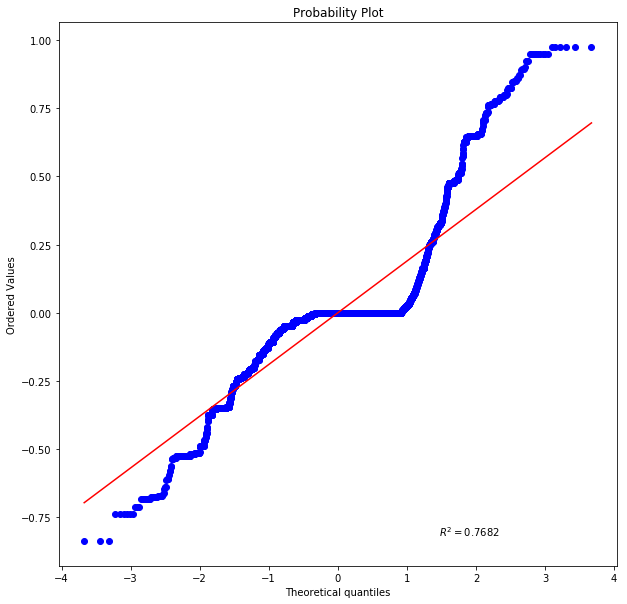

In [12]:
#### ANOVA test ######
scalefree_inflcascades_medians = (scalefree_inflcascades_df.groupby(by=["platform","community","level"])
                                  .median().fillna(0).reset_index())
res_df = pd.DataFrame()

for platform in ["GitHub","Twitter"]:
    for community in ["Crypto","CVE"]:
        df_SF = scalefree_inflcascades_medians[(scalefree_inflcascades_meidans["platform"]==platform) & 
                                               (scalefree_inflcascades_meidans["community"]==community)]
        df_gt = empirical_inflcascades_df[(empirical_inflcascades_df["platform"]==platform) & 
                                          (empirical_inflcascades_df["community"]==community)]
        root_users=set(df_gt.root.unique())
        random.seed(0)
        random_root_users_sample = random.sample(root_users,k=40)
        for user in random_root_users_sample:
            user_df_gt = df_gt[df_gt["root"] == user]
            user_df_gt = user_df_gt.drop(columns="root")
            temp_residual_df = (user_df_gt.set_index(["platform","community","level"])
            .subtract(df_SF.set_index(["platform","community","level"]), fill_value=0).reset_index())
            res_df = res_df.append(temp_residual_df)

res_df = res_df[res_df["level"]<=4]
res_df["platform_community"] = res_df["platform"]+"_"+res_df["community"]
anova_data=pd.melt(res_df, id_vars=["level","platform_community"], value_vars=relationshipTypes, var_name="inf_relationship", value_name="influence")

###### Three-way ANOVA: #####
###### Normality check for each combination of groups of the platform_community, influence relationship and level ######
threewayAnovaNormality=(anova_data.groupby(["platform_community","inf_relationship","level"])
         .apply(lambda x: pd.Series(scipy.stats.shapiro(x), index=['stats','P']))
         .reset_index())
threewayAnovaNormality["H_0"] = threewayAnovaNormality["P"].apply(lambda x: "rejected" if x<0.05 else "not rejected")
print("Three-way ANOVA Normality test", threewayAnovaNormality,sep='\n')
# print(f'{threewayAnovaNormality.groupby(["H_0"]).count()}')
print(f'{threewayAnovaNormality.groupby(["H_0"])["P"].count()}')
threewayAnovaNormality = threewayAnovaNormality.rename(columns={"platform_community":"platformCommunity","inf_relationship":"infRelationship","H_0":"Null"})
threewayAnovaNormality["platformCommunity"]=threewayAnovaNormality["platformCommunity"].str.replace("_","-")
threewayAnovaNormality["stats"] = threewayAnovaNormality["stats"].map("{:.2f}".format)
threewayAnovaNormality["P"] = threewayAnovaNormality["P"].map("{:.2E}".format)
threewayAnovaNormality.to_csv("threewayANOVANormalityStats.csv",index=False)


# #####Two-way ANOVA normality check #####
# twowayAnovaNormality=(anova_data.groupby(["platform_community","inf_relationship"])
#          .apply(lambda x: pd.Series(scipy.stats.shapiro(x), index=['stats','P']))
#          .reset_index())
# twowayAnovaNormality["H_0"] = twowayAnovaNormality["P"].apply(lambda x: "rejected" if x<0.05 else "not rejected")
# print("Two-way ANOVA Normality test", twowayAnovaNormality,sep='\n')
# print(f'{twowayAnovaNormality.groupby(["H_0"]).count()}')

 
#### Three-way ANOVA: Normality check of residuals of the model####
model = ols('influence~C(platform_community)+C(inf_relationship)+C(level)+C(platform_community):C(inf_relationship)+C(platform_community):C(level)+C(inf_relationship):C(level)+C(platform_community):C(inf_relationship):C(level)', data=anova_data).fit()
print(f'Normality check of residuals of the three-way ANOVA model: {scipy.stats.shapiro(model.resid)}')

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)
normality_plot, stat = scipy.stats.probplot(model.resid, plot= plt, rvalue= True)
# ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()



In [85]:
rootchild_data = pd.concat([empirical_rootchild_df,scalefree_rootchild_df], axis=0)
user_count_at_levels = rootchild_data.groupby(["platform","community","platform_community","root","node_level"]).size().reset_index().rename(columns={0:"num_nodes"})
avg_user_count_at_levels = user_count_at_levels.groupby(["platform","community","platform_community","node_level"]).mean().reset_index()
avg_user_count_at_levels["network"] = avg_user_count_at_levels["platform_community"].apply(lambda x: "SF" if "SF" in x else "GT") 
avg_user_count_at_levels["community"] = avg_user_count_at_levels[["network","community"]].agg("_".join,axis=1)
# std_user_count_at_levels = user_count_at_levels.groupby(["platform_community","node_level"]).std().reset_index()
avg_user_count_at_levels["diff"] = avg_user_count_at_levels.groupby("platform_community")["num_nodes"].diff(periods=1)
avg_user_count_at_levels["cumulative_sum_of_users"] = avg_user_count_at_levels.groupby("platform_community")["num_nodes"].apply(lambda x: x.cumsum())
avg_user_count_at_levels["norm_num_nodes"] = avg_user_count_at_levels.groupby("platform_community")["num_nodes"].apply(lambda x : x/x.max())
avg_user_count_at_levels["norm_cumulative_sum_of_users"] =avg_user_count_at_levels.groupby("platform_community")["cumulative_sum_of_users"].apply(lambda x: x/x.max())
avg_user_count_at_levels["norm_diff"] = avg_user_count_at_levels.groupby("platform_community")["diff"].apply(lambda x : x/abs(x).max())
avg_user_count_at_levels

,platform,community,platform_community,node_level,num_nodes,network,diff,cumulative_sum_of_users,norm_num_nodes,norm_cumulative_sum_of_users,norm_diff
0,GitHub,GT_CVE,GitHub_CVE,0,1.000000,GT,NaN,1.000000,0.107914,0.034715,NaN
1,GitHub,GT_CVE,GitHub_CVE,1,4.666667,GT,3.666667,5.666667,0.503597,0.196717,0.789603
2,GitHub,GT_CVE,GitHub_CVE,2,9.266667,GT,4.600000,14.933333,1.000000,0.518407,0.990592
3,GitHub,GT_CVE,GitHub_CVE,3,7.693069,GT,-1.573597,22.626403,0.830187,0.785469,-0.338868
4,GitHub,GT_CVE,GitHub_CVE,4,3.049383,GT,-4.643687,25.675785,0.329070,0.891328,-1.000000
5,GitHub,GT_CVE,GitHub_CVE,5,1.130435,GT,-1.918948,26.806220,0.121989,0.930571,-0.413238
6,GitHub,GT_CVE,GitHub_CVE,6,1.000000,GT,-0.130435,27.806220,0.107914,0.965285,-0.028089
7,GitHub,GT_CVE,GitHub_CVE,7,1.000000,GT,0.000000,28.806220,0.107914,1.000000,0.000000
8,GitHub,SF_CVE,SF_GitHub_CVE,0,1.000000,SF,NaN,1.000000,0.017279,0.008615,NaN
9,GitHub,SF_CVE,SF_GitHub_CVE,1,5.833333,SF,4.833333,6.833333,0.100792,0.058866,0.099656


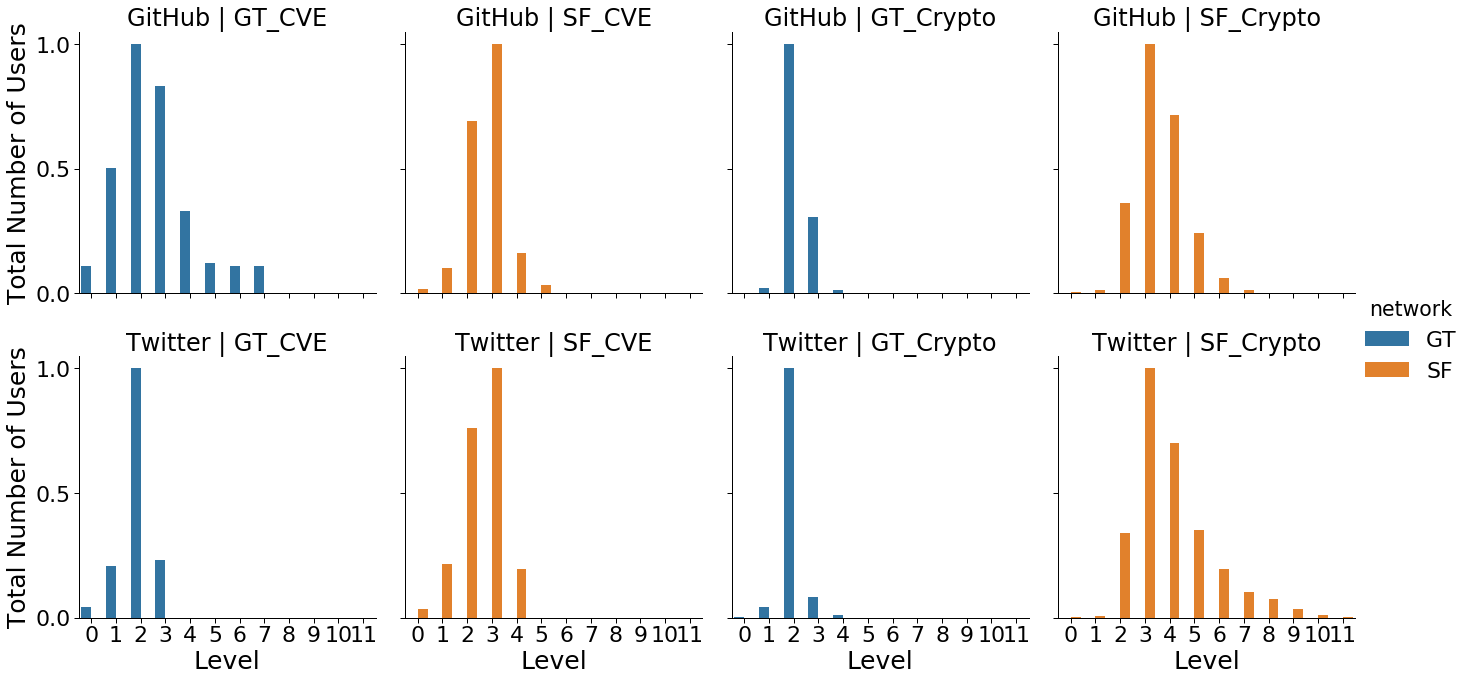

In [256]:
import matplotlib.ticker as ticker
with sns.plotting_context("paper",font_scale=2.5):
    h1 = sns.catplot(x="node_level", y="norm_num_nodes", row="platform",col="community",hue="network",palette=["C0","C1"],kind="bar",
                data=avg_user_count_at_levels)
    h1.axes[0][0].yaxis.set_major_locator(ticker.MultipleLocator(0.5))
#     h1.axes[0][1].xaxis.set_major_locator(ticker.LinearLocator(4))
    h1.set_xlabels("Level",fontsize= 25)
    h1.set_ylabels("Total Number of Users",fontsize= 25)
    h1.set_titles('{row_name}' ' | ' '{col_name}',fontsize=25)
    h1.fig.subplots_adjust(wspace=0.1)
plt.show()


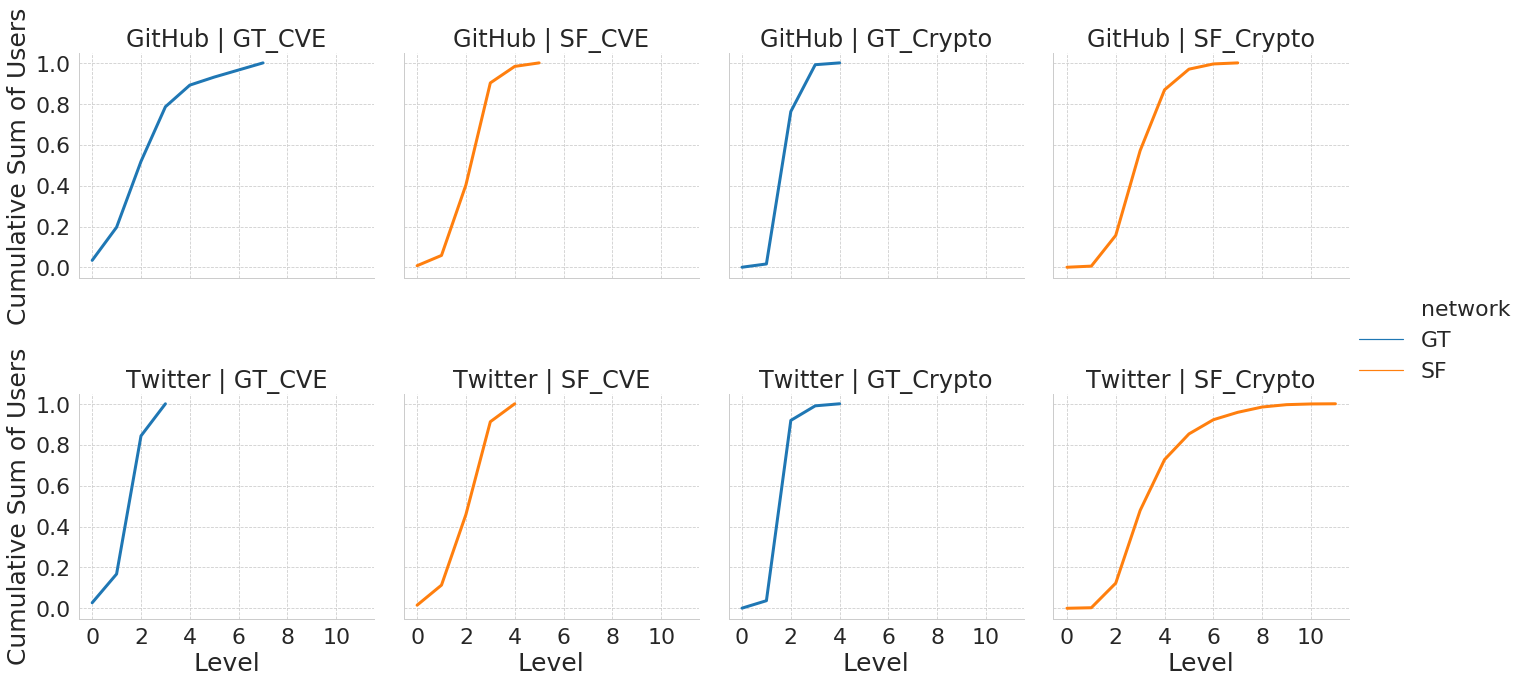

In [257]:
with plt.rc_context(dict(sns.axes_style("whitegrid",{'grid.linestyle': '--'}),
                         **sns.plotting_context("paper", font_scale=2.5))):
    h2=sns.relplot(x="node_level", y="norm_cumulative_sum_of_users", row="platform",col="community",hue="network",palette=["C0","C1"],
                   kind="line", data=avg_user_count_at_levels, linewidth=3)
    
#     h2.axes[0][0].yaxis.set_major_locator(ticker.MultipleLocator(0.25))
    h2.set_xlabels("Level",fontsize= 25)
    h2.set_ylabels("Cumulative Sum of Users",fontsize= 25)
    h2.set_titles('{row_name}' ' | ' '{col_name}',fontsize=25)
    h2.fig.subplots_adjust(wspace=0.1)
#     h2._legend.set_title("Networks")

#     for lh in h2._legend.legendHandles: 
#         print(lh)
#         lh.set_alpha(1)
#         lh.set_sizes = [100]

plt.show()

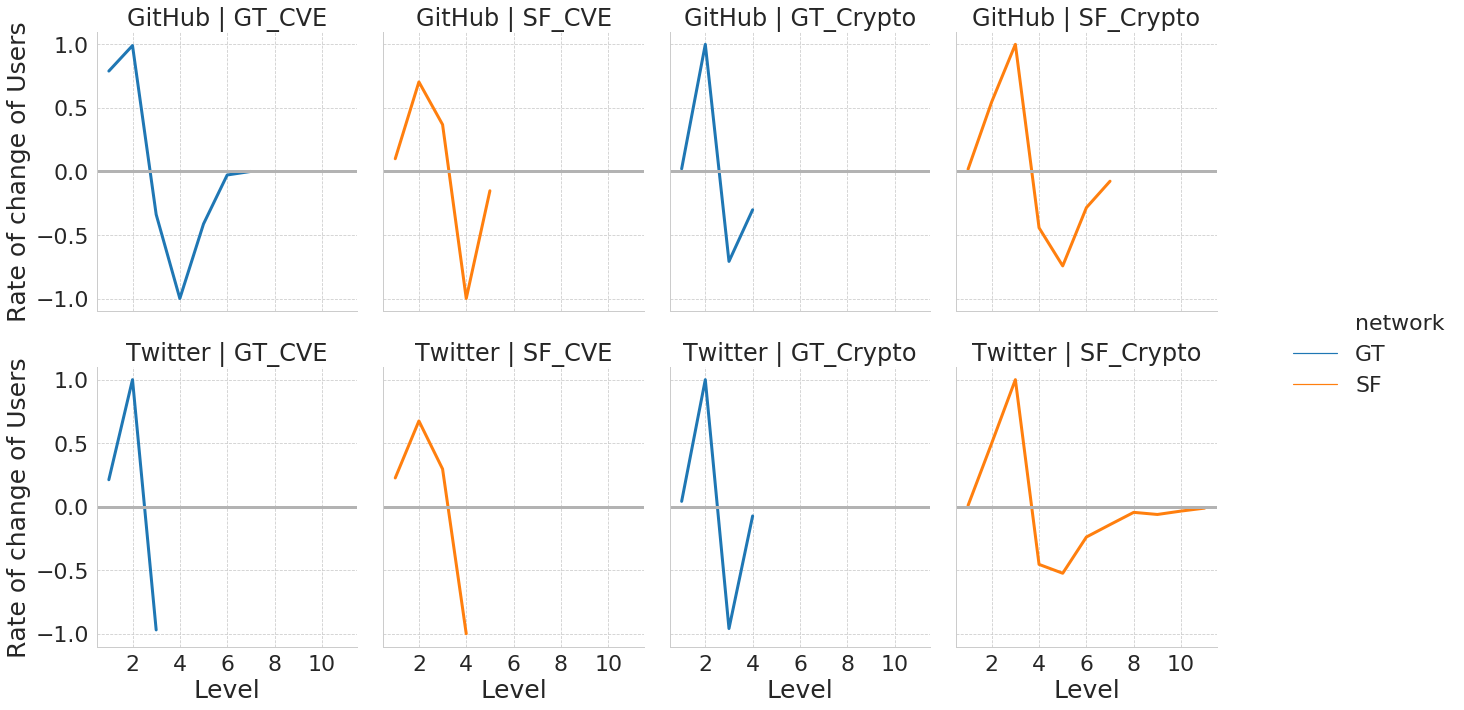

In [258]:
with plt.rc_context(dict(sns.axes_style("whitegrid",{'grid.linestyle': '--'}),
                         **sns.plotting_context("paper", font_scale=2.5))):
    h3=sns.relplot(x="node_level", y="norm_diff", row="platform",col="community",hue="network",palette=["C0","C1"],
                   kind="line", data=avg_user_count_at_levels, linewidth=3)
    (h3.map(plt.axhline, y=0, color=".7", dashes="", lw=3))
    h3.axes[0][0].yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    h3.set_xlabels("Level",fontsize= 25)
    h3.set_ylabels("Rate of change of Users",fontsize= 25)
    h3.set_titles('{row_name}' ' | ' '{col_name}',fontsize=25)
    h3.fig.subplots_adjust(wspace=0.1)
    
plt.show()